# Analiza zvočnih signalov: Samoglasniki, Žvižg, in Beseda "erozija"

V tej nalogi obravnavamo snemanje, prikazovanje in analizo zvočnih signalov za različne samoglasnike, žvižg ter besedo "erozija". Uporabljeni bodo postopki vizualizacije ter križne korelacije za analizo podobnosti signalov.

In [219]:
import numpy as np
import matplotlib.pyplot as plt
from audio_analysis import record_audio
import os
from scipy import signal

In [308]:

def estimate_period_autocorr(signal, sample_rate, max_freq=1000):
    """
    Estimate fundamental period using autocorrelation.
    """
    signal = signal - np.mean(signal)  # Remove DC offset
    corr = np.correlate(signal, signal, mode='full')
    corr = corr[len(corr)//2:]  # Keep only positive lags

    # Ignore the zero-lag peak and restrict to max expected frequency
    min_lag = int(sample_rate / max_freq)
    corr[:min_lag] = 0

    peak_lag = np.argmax(corr)
    if peak_lag == 0:
        return None
    return peak_lag / sample_rate  # period in seconds

def plot_audio_signal(audio_data, sample_rate, title="Audio Signal"):
    """
    Plot the full audio signal and a zoomed-in view of ~10 periods.
    """
    time = np.arange(len(audio_data)) / sample_rate
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot full signal
    ax1.plot(time, audio_data)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    ax1.set_title(f'{title} - Full Signal')
    ax1.grid(True)

    # Estimate period using autocorrelation
    period = estimate_period_autocorr(audio_data, sample_rate)
    
    if period is not None:
        zoom_duration = period * 4
        zoom_samples = int(zoom_duration * sample_rate)

        # Center zoom on max amplitude
        max_idx = np.argmax(np.abs(audio_data))
        start_idx = max(0, max_idx - zoom_samples // 2)
        end_idx = min(len(audio_data), start_idx + zoom_samples)

        # Adjust if at end of signal
        if end_idx - start_idx < zoom_samples:
            start_idx = max(0, end_idx - zoom_samples)

        ax2.plot(time[start_idx:end_idx], audio_data[start_idx:end_idx])
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Amplitude')
        ax2.set_title(f'{title} - Zoomed View (~4 periods)')
        ax2.grid(True)
    else:
        ax2.set_title('Zoomed View - Period not detected')
        ax2.axis('off')

    plt.tight_layout()
    return fig

def trim_signal(audio_data, sample_rate, target_duration, threshold_ratio=0.02):
    """
    Trim leading/trailing silence using energy, then pad or cut to target_duration.
    """
    energy = np.abs(audio_data)
    threshold = threshold_ratio * np.max(energy)
    mask = energy > threshold

    if not np.any(mask):
        return np.zeros(int(target_duration * sample_rate))  # silence if no signal detected

    start = np.argmax(mask)
    end = len(audio_data) - np.argmax(mask[::-1])
    trimmed = audio_data[start:end]

    target_samples = int(target_duration * sample_rate)

    if len(trimmed) > target_samples:
        return trimmed[:target_samples]
    elif len(trimmed) < target_samples:
        # pad with zeros
        padding = target_samples - len(trimmed)
        return np.pad(trimmed, (0, padding), mode='constant')
    return trimmed


def trim_silence(signal, threshold=0.01, sample_rate=16000, padding=0.05):
    """
    Trims silence from the start and end of a signal.
    
    Parameters:
        signal (np.ndarray): The audio signal.
        threshold (float): Amplitude threshold for detecting speech.
        sample_rate (int): Sample rate of the signal.
        padding (float): Padding (in seconds) to keep before and after the speech.
    
    Returns:
        np.ndarray: Trimmed signal.
    """
    abs_signal = np.abs(signal)
    above_thresh = np.where(abs_signal > threshold)[0]
    
    if above_thresh.size == 0:
        return signal  # No speech found

    start = max(above_thresh[0] - int(padding * sample_rate), 0)
    end = min(above_thresh[-1] + int(padding * sample_rate), len(signal))
    
    return signal[start:end]

## Snemanje zvočnih signalov

Snemamo:
- Samoglasnike "a", "i", "o" pri dveh različnih višinah tona
- Žvižg pri dveh višinah
- Besedo "erozija" pri dveh hitrostih


In [394]:
# Ustvari mapo za shranjevanje grafov
os.makedirs('plots', exist_ok=True)

# Parametri snemanja
duration = 3  # seconds
sample_rate = 44100

# Slovar za shranjevanje posnetkov
recordings = {}

vowels = ['a', 'i', 'o']

In [405]:

recordings = {}

print("\nRecording vowel 'a' at first pitch...")
recordings['a_1'], _ = record_audio(duration, sample_rate)

print("\nRecording vowel 'a' at second pitch...")
recordings['a_2'], _ = record_audio(duration, sample_rate)


Recording vowel 'a' at first pitch...
Recording for 3 seconds...
Recording finished

Recording vowel 'a' at second pitch...
Recording for 3 seconds...
Recording finished


In [406]:
print("\nRecording vowel 'i' at first pitch...")
recordings['i_1'], _ = record_audio(duration, sample_rate)

print("\nRecording vowel 'i' at second pitch...")
recordings['i_2'], _ = record_audio(duration, sample_rate)


Recording vowel 'i' at first pitch...
Recording for 3 seconds...
Recording finished

Recording vowel 'i' at second pitch...
Recording for 3 seconds...
Recording finished


In [407]:
print("\nRecording vowel 'o' at first pitch...")
recordings['o_1'], _ = record_audio(duration, sample_rate)

print("\nRecording vowel 'o' at second pitch...")
recordings['o_2'], _ = record_audio(duration, sample_rate)


Recording vowel 'o' at first pitch...
Recording for 3 seconds...
Recording finished

Recording vowel 'o' at second pitch...
Recording for 3 seconds...
Recording finished


In [272]:
print("\nRecording whistling at first pitch...")
recordings['whistle_1'], _ = record_audio(duration, sample_rate)

print("\nRecording whistling at second pitch...")
recordings['whistle_2'], _ = record_audio(duration, sample_rate)


Recording whistling at first pitch...
Recording for 3 seconds...
Recording finished

Recording whistling at second pitch...
Recording for 3 seconds...
Recording finished


In [476]:
print("\nRecording word 'erozija' at first speed...")
recordings['erozija_1'], _ = record_audio(duration, sample_rate)

# print("\nRecording word 'erozija' at second speed...")
# recordings['erozija_2'], _ = record_audio(duration, sample_rate)


Recording word 'erozija' at first speed...
Recording for 3 seconds...
Recording finished


## Vizualizacija signalov

Prikazani so vsi posneti signali z:
- celotnim signalom
- povečanim odsekom (3–4 periode)


In [ ]:
for name, data in recordings.items():
    fig = plot_audio_signal(data, sample_rate, title=f"Signal: {name}")
    plt.show()

## Križna korelacija

Analiza s križno korelacijo za iskanje samoglasnikov v izgovorjavi besede "erozija".


In [481]:
from IPython.display import Audio, display
from scipy.io.wavfile import write
import os

vowel_duration = 0.5
download_count = 0  # Counter to track how many audios we save
max_downloads = 3   # We want to save only 3 audios

# Ensure output directory exists
os.makedirs("downloads", exist_ok=True)

# Function to trim and listen vowels
print("Listening to trimmed vowels:")

trimmed_vowels = {}

# First versions: only listen
for vowel in vowels:
    trimmed = trim_signal(recordings[f'{vowel}_1'], sample_rate, vowel_duration)
    trimmed_vowels[f'{vowel}_1'] = trimmed

    print(f"Trimmed vowel '{vowel}':")
    display(Audio(trimmed, rate=sample_rate))

# Second versions: listen and download
for vowel in vowels:
    trimmed = trim_signal(recordings[f'{vowel}_2'], sample_rate, vowel_duration)
    trimmed_vowels[f'{vowel}_2'] = trimmed

    print(f"Trimmed vowel '{vowel}' 2:")
    display(Audio(trimmed, rate=sample_rate))

    # Save to file for download (only first 3)
    if download_count < max_downloads:
        filename = f"downloads/{vowel}_2_trimmed.wav"
        write(filename, sample_rate, trimmed)
        print(f"Saved: {filename}")
        download_count += 1

# Erozija samples
trimmed_erozija_1 = trim_silence(recordings['erozija_1'], sample_rate=sample_rate)
trimmed_erozija_2 = trim_silence(recordings['erozija_2'], sample_rate=sample_rate)

# Listen to trimmed versions
print("Trimmed 'erozija_1':")
display(Audio(trimmed_erozija_1, rate=sample_rate))

print("Trimmed 'erozija_2':")
display(Audio(trimmed_erozija_2, rate=sample_rate))


Listening to trimmed vowels:
Trimmed vowel 'a':


Trimmed vowel 'i':


Trimmed vowel 'o':


Trimmed vowel 'a' 2:


Saved: downloads/a_2_trimmed.wav
Trimmed vowel 'i' 2:


Saved: downloads/i_2_trimmed.wav
Trimmed vowel 'o' 2:


Saved: downloads/o_2_trimmed.wav
Trimmed 'erozija_1':


Trimmed 'erozija_2':


In [466]:
import numpy as np
from scipy.signal import correlate
import soundfile as sf


def create_vowel_template(vowel, sample_rate, duration=0.5):
    """
    Generates a simple sinusoidal template for a given vowel.
    """
    frequency_map = {'a': 700, 'i': 2300, 'o': 500}
    frequency = frequency_map.get(vowel)
    if frequency is None:
        raise ValueError(f"Vowel '{vowel}' not supported.")
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    template = np.sin(2 * np.pi * frequency * t)
    return template

def find_best_match_segment(signal, template, sample_rate):
    """
    Finds the best matching segment of the signal for the template using normalized cross-correlation.

    Returns:
        tuple: (best_start_time, best_end_time, best_score)
    """
    template = (template - np.mean(template)) / np.std(template)
    signal_norm = (signal - np.mean(signal)) / np.std(signal)

    correlation = correlate(signal_norm, template, mode='valid')
    correlation /= len(template)  # normalize by length of the template

    best_index = np.argmax(correlation)
    best_score = correlation[best_index]

    best_start_time = best_index / sample_rate
    best_end_time = (best_index + len(template)) / sample_rate

    return best_start_time, best_end_time, best_score, correlation

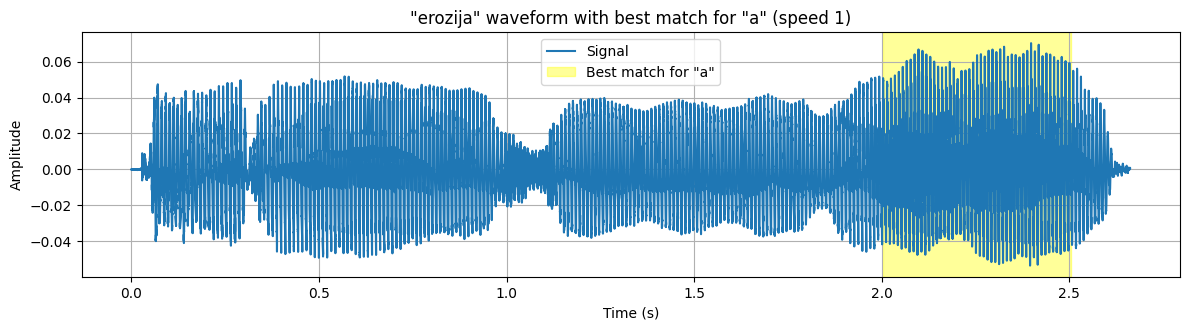

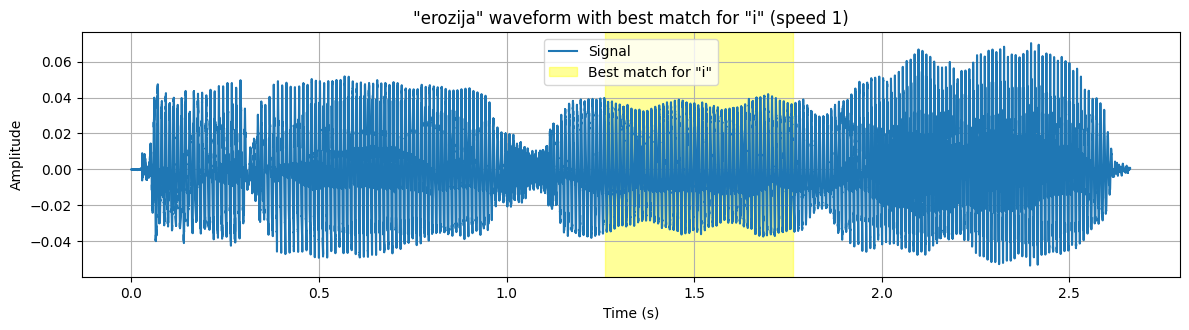

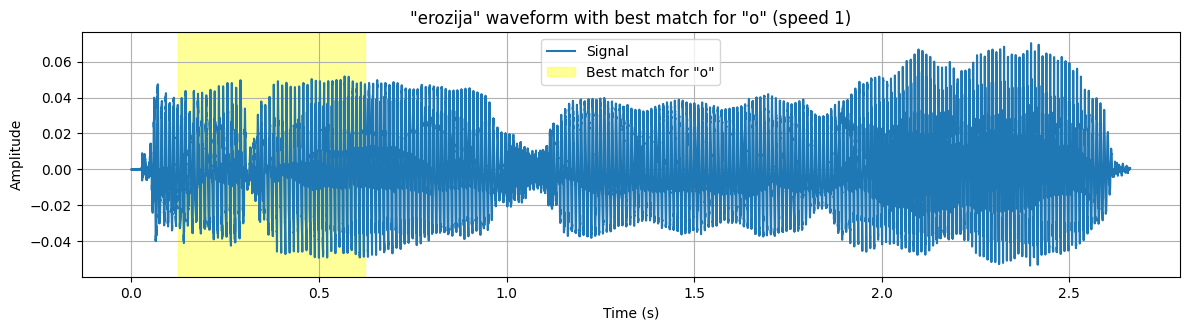

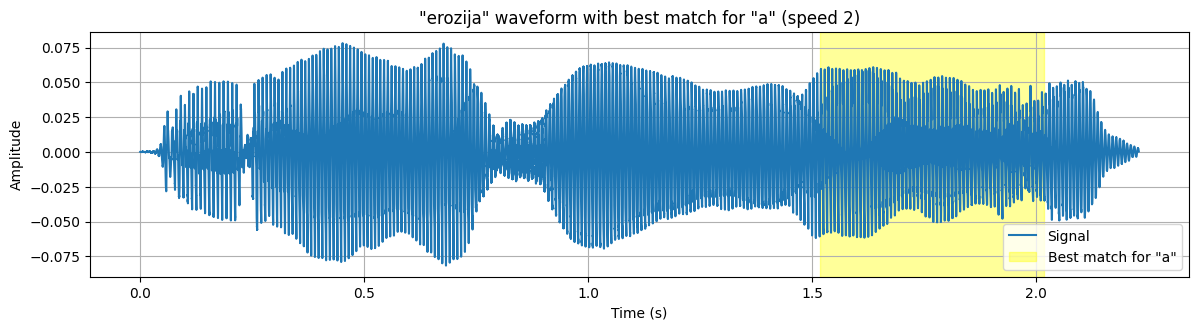

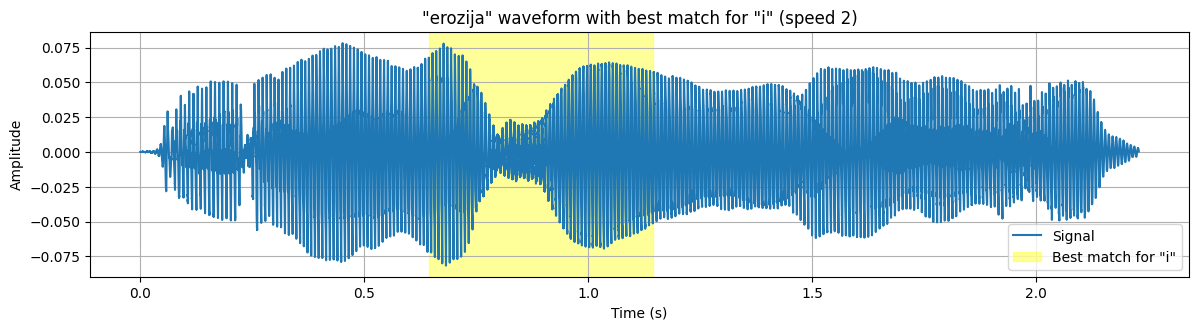

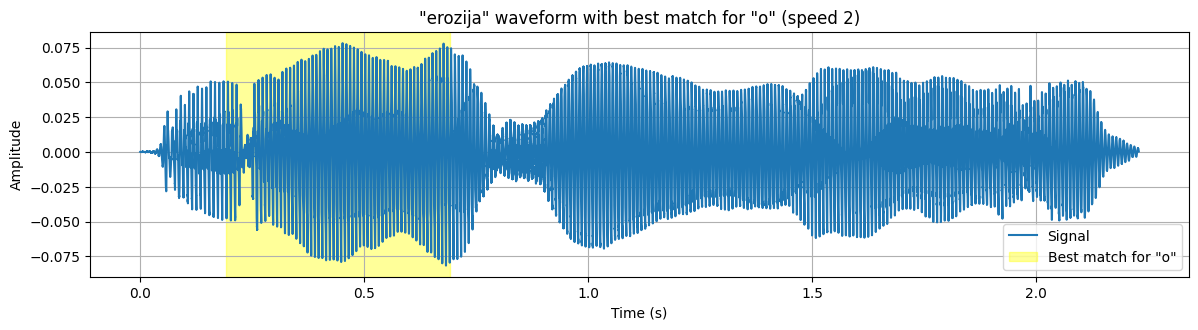

In [478]:
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf

# Define vowels to detect
vowels_to_find = ['a', 'i', 'o']

# Create templates for each vowel
templates = {vowel: create_vowel_template(vowel, sample_rate, duration=0.5) for vowel in vowels_to_find}

# Process both "erozija" signals
for speed in ['1', '2']:
    erozija_signal = trimmed_erozija_1 if speed == '1' else trimmed_erozija_2
    time_erozija = np.arange(len(erozija_signal)) / sample_rate

    for vowel in vowels_to_find:
        template = templates[vowel]
        start_time, end_time, score, correlation = find_best_match_segment(erozija_signal, template, sample_rate)
        corr_time = np.arange(len(correlation)) / sample_rate

        plt.figure(figsize=(12, 6))

        # Plot the signal with best match highlighted
        plt.subplot(2, 1, 1)
        plt.plot(time_erozija, erozija_signal, label='Signal')
        plt.axvspan(start_time, end_time, color='yellow', alpha=0.4, label=f'Best match for "{vowel}"')
        plt.title(f'"erozija" waveform with best match for "{vowel}" (speed {speed})')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()


## Zaključek

- Signal samoglasnikov v besedi "erozija" je podoben samostojnim izgovorjavam, vendar je spremenjen zaradi povezovanja med glasovi.
- Križna korelacija omogoča določitev približnega začetka črke v signalu.
- Žvižg ima pretežno sinusno obliko, značilno za čiste tone.